### Information Retrieval - a.a. 2023/2024 - Sandro Junior Della Rovere (SM3500595) - Final Project

# Music Retrieval - A Boolean Retrieval Approach

## Introduction
The aim of this project is to build a search engine for music retrieval. The search engine is based on a __Boolean retrieval__ approach, which means that the user can search for songs by specifying a query composed of one or more keywords and boolean operators. The search engine will return all the songs for which the query is satisfied. The collection of songs that is used for the retrieval is the [Spotify Million Song Dataset](https://www.kaggle.com/datasets/notshrirang/spotify-million-song-dataset), which is a freely-available collection of song lyrics. The _Boolean Retrieval System_ is composed of an _Inverted Index_, which is a data structure that maps each term in the dictionary (all the terms in the collection) to the posting list of documents (songs) that contain that term. Boolean Retrieval is not the most cutting-edge approach for Information Retrieval, in fact it's one of the simplest and most basic ones. However, it's a good starting point to understand how IR works and to build a simple search engine.

In this project an inverted index is going to be implemented, then it will be used to index the songs in the dataset, and at the end an evaluation of the system will be presented.

## Implementation

In [138]:
# Load libraries

## Python version is 3.11.6

## pandas is used to manipulate dataframes
import pandas as pd
pd.set_option('display.max_columns', None)

## numpy is used to manipulate arrays
import numpy as np

## nltk is used to perform stemming, lemmatization and stop word removal
import nltk
nltk.download('wordnet')
nltk.download('stopwords')

## string is used to manipulate strings, in particular to remove punctuation in the normalization phase
import string

## re is used to perform regular expression operations, in particular it's used to generate queries for the evaluation phase
import re

## total_ordering is a function decorator that fills in missing ordering methods, such as __lt__, __gt__, __le__, and __ge__
from functools import total_ordering

## pickle is used to save python objects to disk, and load them back to memory
import _pickle as pickle # cPickle performs slightly better than pickle

## matplotlib and seaborn are used to plot graphs
import matplotlib.pyplot as plt
import seaborn as sns

## removing some annoying warnings that appear when plotting graphs
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package wordnet to /home/akasnipe/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/akasnipe/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Data exploration

Data analysis is out of scope for this project, however, some basic exploration has been done to understand the dataset and how to manipulate it.

The dataset contains 57.650 songs, each song is represented by the following attributes:
- `artist`: name of the artist (singer/band/musician/...) that performed the song
- `song`: title of the song
- `link`: link to the song, it's not clear what this link is referring to, but it's not relevant for this project
- `text`: lyrics of the song

In [139]:
data = pd.read_csv('data/spotify_millsongdata.csv', sep=",")
data

,artist,song,link,text
0,ABBA,Ahe's My Kind Of Girl,/a/abba/ahes+my+kind+of+girl_20598417.html,"Look at her face, it's a wonderful face \nAnd..."
1,ABBA,"Andante, Andante",/a/abba/andante+andante_20002708.html,"Take it easy with me, please \nTouch me gentl..."
2,ABBA,As Good As New,/a/abba/as+good+as+new_20003033.html,I'll never know why I had to go \nWhy I had t...
3,ABBA,Bang,/a/abba/bang_20598415.html,Making somebody happy is a question of give an...
4,ABBA,Bang-A-Boomerang,/a/abba/bang+a+boomerang_20002668.html,Making somebody happy is a question of give an...
...,...,...,...,...
57645,Ziggy Marley,Good Old Days,/z/ziggy+marley/good+old+days_10198588.html,Irie days come on play \nLet the angels fly l...
57646,Ziggy Marley,Hand To Mouth,/z/ziggy+marley/hand+to+mouth_20531167.html,Power to the workers \nMore power \nPower to...
57647,Zwan,Come With Me,/z/zwan/come+with+me_20148981.html,all you need \nis something i'll believe \nf...
57648,Zwan,Desire,/z/zwan/desire_20148986.html,northern star \nam i frightened \nwhere can ...


Only `artist`, `song`  and `text` will be used for the retrieval, so column `link` will be dropped.

In [141]:
data = data.drop('link', axis=1)
data.head(5)

,artist,song,text
0,ABBA,Ahe's My Kind Of Girl,"Look at her face, it's a wonderful face \nAnd..."
1,ABBA,"Andante, Andante","Take it easy with me, please \nTouch me gentl..."
2,ABBA,As Good As New,I'll never know why I had to go \nWhy I had t...
3,ABBA,Bang,Making somebody happy is a question of give an...
4,ABBA,Bang-A-Boomerang,Making somebody happy is a question of give an...


Notice that the song lyrics need some preprocessing, in fact they contain some special characters ("\r", "\n") that need to be removed. The preprocessing will be done later.

Now let's dive into the creation of the IR system.

### IR System

The system will be composed of the following classes:
* Posting: The class to implement the Postings, 
* Posting List: The class to implement the Posting Lists,
* Term: The class to implement the Terms of the dictionary,
* Inverted Index: The class to implement the Inverted Index,
* Song: The class to implement the Songs,
* IR System: The "main" class that puts everything together.

In [4]:
# Posting class

@total_ordering
class Posting:
    
    # Initializer, takes a document ID as an argument
    def __init__(self, docID):
        self._docID = docID
    
    # Retrieve a document's contents from a corpus using the document ID
    def get_from_corpus(self, corpus):
        return corpus[self._docID]
    
    # Check equality with another Posting, based on document ID
    def __eq__(self, other):
        return self._docID == other._docID
    
    # Check if this Posting has document ID greater than another Posting
    def __gt__(self, other):
        return self._docID > other._docID
    
    # Provide the string representation of the Posting
    def __repr__(self):
        return str(self._docID)

In [5]:
# Posting List class

class PostingList:

    # Initializer, initializes an empty list of postings
    def __init__(self):
        self._postings = []
    
    # Create a PostingList instance with a single Posting from a document ID
    @classmethod
    def from_docID(cls, docID):
        posting_list = cls()
        posting_list._postings = [(Posting(docID))]
        return posting_list
    
    # Create a PostingList instance from an existing list of Postings
    @classmethod
    def from_posting_list(cls, postingList):
        plist = cls()
        plist._postings = postingList
        return plist

    # Merge another PostingList into this one, avoiding duplicates
    def merge(self, other):
        i = 0  # Index for the other PostingList.
        last = self._postings[-1]  # The last Posting in the current list

        while (i < len(other._postings) and last == other._postings[i]):
            i += 1  # Increment the index if a duplicate is found.
        self._postings += other._postings[i:]  # Append the non-duplicate postings from the other list

    # Retrieve the contents of each Posting from a corpus
    def get_from_corpus(self, corpus):
        return list(map(lambda x: x.get_from_corpus(corpus), self._postings))
    
    # Provide the string representation of the PostingList
    def __repr__(self):
        return ", ".join(map(str, self._postings))

In [6]:
# Term class

# Exception class for handling merge operation errors
class ImpossibleMergeError(Exception):
    pass

# A class that represents a term in a document, along with its posting list
@total_ordering
class Term:

    # Initializer, takes a term and a document ID as arguments
    def __init__(self, term, docID):
        self.term = term
        # Initialize posting_list for the term with a PostingList created from the given document ID
        self.posting_list = PostingList.from_docID(docID)

    # Merge another Term's posting list into this one if they have the same term
    def merge(self, other):
        if (self.term == other.term):
            self.posting_list.merge(other.posting_list)
        else:
            raise ImpossibleMergeError
    
    # Check equality with another Term
    def __eq__(self, other):
        return self.term == other.term
    
    # Determine if this Term is greater than another
    def __gt__(self, other):
        return self.term > other.term
    
    # Provide the string representation of the Term
    def __repr__(self):
        return self.term + ": " + repr(self.posting_list)

Before defining the Inverted Index class, let's define functions to perform normalization, stemming and lemmatization.

In [7]:
# Stop Word removal, Normalization and Stemming/Lemmatization

def remove_stop_words(text):
     
    # Start from a list containing the tokens in "text"
    text_list = text.split()

    # Filter out stop words
    text_list = [word for word in text_list if word not in set(nltk.corpus.stopwords.words('english'))]

    # Join the remaining words into a single string
    result = " ".join(text_list)

    return result

def normalize(text):

    # Make a translation table that maps all punctuation characters to None
    translator = str.maketrans("", "", string.punctuation)

    # Apply the translation table to the input string
    result = text.translate(translator)

    # Converts the text to lowercase.
    result = result.lower()

    return result

def stem(text, type='porter'):
        
    # Start from a list containing the tokens in "text"
    stemmed_text = text.split()

    # Create a stemmer object
    if type == 'porter':
        stemmer = nltk.stem.porter.PorterStemmer()
    elif type == 'snowball':
        stemmer = nltk.stem.snowball.SnowballStemmer("english")
    else:
        raise ValueError('Stemmer type not supported')

    # Loop through each word in the text and retrieve the stem
    for i in range(len(stemmed_text)):
        stemmed_text[i] = stemmer.stem(stemmed_text[i])

    # Join the stemmed words into a single string
    result = " ".join(stemmed_text)

    return result

def lemmatize(text):
     # Start from a list containing the tokens in "text"
        lemmatized_text = text.split()
    
        # Create a lemmatizer object
        lemmatizer = nltk.stem.WordNetLemmatizer()
    
        # Loop through each word in the text and retrieve the lemma
        for i in range(len(lemmatized_text)):
            lemmatized_text[i] = lemmatizer.lemmatize(lemmatized_text[i])
    
        # Join the lemmatized words into a single string
        result = " ".join(lemmatized_text)
    
        return result

Now the class for the inverted index is going to be defined, this index will consider a dictionary composed of the single words and of the bigrams, also trigrams or, more generally, n-grams could be considered, but for this project only single words and bigrams have been implemented to show how the system works, any further improvement is not a major change code-wise.

In [142]:
# Inverted Index class

class InvertedIndex:
    
    # Initialize the inverted index with an empty dictionary
    def __init__(self):
        self._dictionary = []
        
    # Create an inverted index from a corpus of documents
    ## Argument word_reduction_type enables to choose between stemming and lemmatization
    ## Argument stop_words enables to maintain stop words (stop_words=True) or remove them (stop_words=False)
    @classmethod
    def from_corpus(cls, corpus, word_reduction_type = 'stemming_porter', stop_words = True):
        intermediate_dict = {}  # Intermediate dictionary to store the terms and their postings
        for docID, song in enumerate(corpus):
            document = song.lyrics
            # Remove stop words, normalize and stem/lemmatize
            document = normalize(document)
            if not stop_words:
                document = remove_stop_words(document)
            if word_reduction_type == 'stemming_porter':
                document = stem(document, type = 'porter')
            elif word_reduction_type == 'stemming_snowball':
                document = stem(document, type = 'snowball')
            elif word_reduction_type == 'lemmatization':
                document = lemmatize(document)
            tokens_list = document.split() # Tokenize the document into individual words
            tokens = set(tokens_list) # Remove duplicates         
            biwords = set([tokens_list[i]+' '+tokens_list[i+1] for i in range(len(tokens_list)-1)]) # Get all biwords in the document, remove duplicates
            for token in tokens:
                term = Term(token, docID) # Create a new term with the token and the current document ID
                try: # Try to merge the term with existing one in the intermediate dictionary
                    intermediate_dict[token].merge(term)
                except KeyError: # If the term is not already in the dictionary, add it
                    intermediate_dict[token] = term
            for biword in biwords:
                term = Term(biword, docID) # Create a new term with the biword and the current document ID
                try: # Try to merge the term with existing one in the intermediate dictionary
                    intermediate_dict[biword].merge(term)
                except KeyError: # If the term is not already in the dictionary, add it
                    intermediate_dict[biword] = term
        idx = cls() # Create a new InvertedIndex instance.
        idx._dictionary = sorted(intermediate_dict.values(), key=lambda term: term.term) # Sort the terms in the intermediate dictionary and store them in the index's dictionary
        return idx
    
    # Retrieve the posting list for a given term
    def __getitem__(self, key):
        for term in self._dictionary:
            if term.term == key: # If the term matches the key, return its posting list
                return term.posting_list
        raise KeyError("No song matches the given query.") # If the term is not in the dictionary, raise a KeyError
    
    # Provide a string representation of the inverted index
    def __repr__(self):
        return "A dictionary with " + str(len(self._dictionary)) + " terms"

In [9]:
# Song class

# Class to hold the title, author, and lyrics of a song
class Song:
    
    # Initializer, initializes the title, author, and lyrics attributes
    def __init__(self, title, author, lyrics):
        self.title = title
        self.author = author
        self.lyrics = lyrics
        
    # Provide the string representation of the Song object
    def __repr__(self):
        return "Title: " + self.title + ",\nAuthor: " + self.author + "\n\n"
    
# Get song author, title and lyrics from data
def get_songs_data(path):
    data = pd.read_csv(path, sep=",")
    # Remove newline characters from song lyrics
    data['text'] = data['text'].replace('\r\n',' ', regex=True)
    # Initialize an empty corpus
    corpus = []
    # Add all the songs in the data to the corpus
    for index, item in data.iterrows():
        song = Song(title = item['song'],
                    author = item['artist'],
                    lyrics = item['text'])
        # Add the Song object to the corpus
        corpus.append(song)
        
    return corpus


In [10]:
# Information Retrieval (IR) system class

class IRsystem:

    # Initialize the IR system with a corpus and the inverted index 
    def __init__(self, corpus, index):
        self._corpus = corpus
        self._index = index
    
    # Create an IR system instance from a given corpus
    @classmethod
    def from_corpus(cls, corpus, word_reduction_type = 'stemming_porter', stop_words=True):
        index = InvertedIndex.from_corpus(corpus, word_reduction_type, stop_words)
        return cls(corpus, index)
    
    # Return the posting list of a given posting
    def get_posting_list(self, posting):
        # Retrieve the posting list from the index
        posting_list = self._index[posting]
        # Return the list of documents
        return posting_list.get_from_corpus(self._corpus)

Now that the inverted index has been completely defined, the proposed IR system only needs a function to execute the queries and perform the retrieval.

The query is a string composed of one or more keywords and boolean operators, the keywords are the terms that will be searched in the dictionary, the boolean operators are used to combine the keywords and to specify the query. The supported boolean operators are:
* `AND`: both keywords must be present in the song
* `OR`: at least one of the keywords must be present in the song
* `NOT`: the first keyword must be present in the song, but the second one must not be present

Also complex queries are supported, for example: `keyword1 AND keyword2 NOT keyword3`, the query is interpreted from left to right, so in this case the first operation that is performed is `keyword1 AND keyword2`, then the result of this operation is combined with `NOT keyword3`. There is no limit to the number of boolean operators that can be used in a query, however, this IR system doesn't support parentheses, so the order of the operations is always from left to right.

If no boolean operator is specified, the system will search for all the songs that contain the keyword.

Also phrasal queries are supported, for example: `"keyword1 keyword2"`, in this case the query will return all the songs that contain the exact phrase "keyword1 keyword2".

As it is now, the system is only able to perform retrieval of words or bigrams, so phrasal queries with more than two words are not supported, but the extension to n-grams is straightforward.

In [11]:
# Function to execute a text query against an IR system

## Argument word_reduction_type enables to choose between stemming and lemmatization
## Argument stopwords enables to maintain stop words (stopwords=True) or remove them (stopwords=False)
## Argument _print enables to print out the songs that match the query (print=True) or to return them as a set (print=False)
def query(ir, query, word_reduction_type = 'stemming_porter', stopwords = True, _print = True):
    answer = set()
    # Split the text query into individual words/biwords
    words = re.split('(AND|OR|NOT)', query)
    for i in range(len(words)):
        words[i] = words[i].strip()
    # Check if the first or the last word is a boolean operator and return an error.
    if words[0] in ["AND", "OR", "NOT"] or words[len(words)-1] in ["AND", "OR", "NOT"]:
        raise KeyError("The first and the last word of the query cannot be a boolean operator.")
    # Normalize, remove stopwords and stem/lemmatize the words/biwords in the query but not the boolean operators
    for i in range(len(words)):
        if words[i] not in ["AND", "OR", "NOT"]:
            if word_reduction_type == 'stemming_porter':    
                words[i] = normalize(words[i])
                if not stopwords:
                    words[i] = remove_stop_words(words[i])               
                words[i] = stem(words[i], type = 'porter')
            elif word_reduction_type == 'stemming_snowball':
                words[i] = normalize(words[i])
                if not stopwords:
                    words[i] = remove_stop_words(words[i]) 
                words[i] = stem(words[i], type = 'snowball')
            elif word_reduction_type == 'lemmatization':
                words[i] = normalize(words[i])
                if not stopwords:
                    words[i] = remove_stop_words(words[i]) 
                words[i] = lemmatize(words[i])
    # Retrieve the posting list for the first word/biword from the index
    result = ir.get_posting_list(words[0])
    for song in result:
        answer.add(song)
    # Loop through the remaining words in the query
    for i in range(1, len(words), 2):
        # Retrieve the posting lists for the next word from the index
        result = ir.get_posting_list(words[i+1])
        # Case AND: Intersect the current answer with the new posting lists
        if words[i] == "AND":
            answer = answer.intersection(result)
        # Case OR: Unite the current answer with the new posting lists
        elif words[i] == "OR":
            answer = answer.union(result)
        # Case NOT: Subtract the new posting lists from the current answer
        elif words[i] == "NOT":
            answer = answer.difference(result)
    # Print out each song that matches the query
    ## If no song matches the query, print out a message
    if len(answer) == 0:
        raise KeyError("No song matches the given query.")
    if _print:
        for song in answer:
            print(song)
    else:
        return answer

Let's now test the Boolean Retrieval System with different parametrizations.

In [12]:
# Generate the corpus from the data

corpus = get_songs_data("data/spotify_millsongdata.csv")

In [13]:
# Generate and save on disk the IR Systems with different parametrizations

for word_reduction_type in ['stemming_porter', 'stemming_snowball', 'lemmatization']:
    for stopwords in [True, False]:
        ir = IRsystem.from_corpus(corpus, word_reduction_type, stopwords)
        filename = 'IRSystem/ir_' + word_reduction_type + '_with_stopwords' + '.pkl'
        if not stopwords:
            filename = 'IRSystem/ir_' + word_reduction_type + '_without_stopwords' + '.pkl'
        with open(filename, 'wb') as output:
            pickle.dump(ir, output, protocol=5)

Generating the IR system and dumping it on disk takes approximately 70 minutes, this means that each IR system took approximately 10-12 minutes to be generated and saved.

During experimentation, the generation of a single IR system took approximately 6 minutes (with different times for different parametrizations), and also the dumping on disk took almost the same amount of time.

The times may vary from machine to machine, but the order of magnitude should not change much.

__Suggestion__: free up some RAM before running the following cells. Restarting the kernel and running all the cells from 1 to 11 should be enough.

Let's now test the IR system in its default configuration (porter stemming, with stopwords).

In [14]:
# Load the IR system from a file

with open('IRSystem/ir_stemming_porter_with_stopwords.pkl', 'rb') as handle:
    ir = pickle.load(handle)

Loading an Inverted Index from disk takes approximately 1 minute, which is an improvement with respect to the time needed to generate it.

In [15]:
query(ir, "american AND idiot")

Title: American Idiot,
Author: Green Day


Title: American Idiot (Greenday Cover),
Author: Avril Lavigne


Title: Raleigh Soliloquy Pt. Ii,
Author: Sublime


Title: Irresponsible Hate Anthem,
Author: Marilyn Manson




Queries are executed very fast, this is one of the advantages of the Boolean Retrieval approach.

As you can see, the IR system returns (also) the song American Idiot by Green Day, which is expected from the given query.

In [17]:
query(ir, "american AND idiot NOT media")

Title: Raleigh Soliloquy Pt. Ii,
Author: Sublime


Title: Irresponsible Hate Anthem,
Author: Marilyn Manson




If the "NOT media" part is added to the query, the IR system returns the same results as before, but without the song American Idiot by Green Day (and the Avril Lavigne cover), since the word "media" is present in the lyrics of this song, but not in the lyrics of the other two songs that are still retrieved.

In [32]:
query(ir, "american idiot OR work sucks")

Title: American Idiot,
Author: Green Day


Title: All The Small Things (Blink 182 Cover),
Author: Avril Lavigne


Title: American Idiot (Greenday Cover),
Author: Avril Lavigne




Also phrasal queries work as expected, the IR system returned the songs American Idiot (the only song where the phrase "american idiot" is present) and All The Small Things (the only song where the phrase "work sucks" is present).

Let's now evaluate the IR system, with the different parametrizations, and analyze the results.

### IR System Evaluation

Since the chosen dataset only contains the documents used by the IR system, there is no reference dataset for the evaluation.

For this reason, a simple procedure has been implemented, which consists in the generation of random queries, with relevant documents associated to each query. The queries are generated in the following way:
1. Sample some songs from the dataset.
    - For each song, compute the 5 most frequent words/bigrams in the lyrics (including and excluding stopwords, in order to test the IR system with different parametrizations).
    - Use these words for the queries. **A document is considered relevant if the query keyword is among the 5 most frequent ones in the song lyrics**. Other techniques could have been used to determine the relevance of a document, but this one has been thought as simple and effective enough in this tricky situation.
2. Pick 3 words/bigrams at random from the previous result (`word1`, `word2`, `word3`).
3. Loop N times:
    Randomly generate K queries, with K random (ranging from 1 to 6), each one having one of the following 6 structures (again, chosen at random):
    - Simple `AND` query: "word1 AND word2"
    - Simple `OR` query: "word1 OR word2"
    - Simple `NOT` query: "NOT word1"
    - Complex `AND NOT` query: "word1 AND word2 NOT word3"
    - Complex `OR NOT` query: "word1 OR word2 NOT word3"
    - Simple 1 word query: "word1"
    
    Each query is associated to the relevant documents for that query.
3. Run the IR system on the generated queries, compute the precision and recall for each query, and average them over all the queries.
4. Analyze the results.   


In [12]:
# Sample N songs from the dataset

sample = data.sample(n=500, replace=False)

# For each lyrics, compute the frequency of words and biwords, maintain only the 5 most frequent words/biwords

def get_top5_frequencies(corpus, stop_words = True):
    frequencies = pd.DataFrame(columns=['songID', 'song', 'author', 'word', 'frequency'])
    # Loop through each song in the corpus and retrieve the frequencies of words and biwords
    for index, item in corpus.iterrows():
        song = item['song']
        author = item['artist']
        lyrics = item['text']
        # Remove stop words and normalize
        if not stop_words:
                lyrics = normalize(lyrics)
                lyrics = remove_stop_words(lyrics)
        tokens_list = lyrics.split() # Tokenize the lyrics into individual words
        if not stop_words:
            tokens_list = [token for token in tokens_list if len(token) > 3] # Exclude tokens that have less than 4 characters. (e.g. 'she', 'im', 'ive', etc.)
        tokens = set(tokens_list) # Remove duplicates
        biwords_list = [tokens_list[i]+' '+tokens_list[i+1] for i in range(len(tokens_list)-1)] # Get all biwords in the document
        biwords = set(biwords_list) # Remove duplicates
        # Create a temporary dataframe to store the frequencies of words and biwords           
        tmp_frequencies = pd.DataFrame(columns=['songID', 'song', 'author', 'word', 'frequency'])
        for token in tokens:
            tmp_frequencies = pd.concat([tmp_frequencies, pd.DataFrame({'songID': index, 'song': song, 'author': author, 'word': token, 'frequency': tokens_list.count(token)}, index=[0])], ignore_index=True)
        for biword in biwords:
            tmp_frequencies = pd.concat([tmp_frequencies, pd.DataFrame({'songID': index, 'song': song, 'author': author, 'word': biword, 'frequency': biwords_list.count(biword)}, index=[0])], ignore_index=True)
        # Maintain only the 5 most frequent words/biwords
        tmp_frequencies = tmp_frequencies.sort_values(by=['frequency'], ascending=False).head(5)
        # Append the frequencies of words and biwords to the result
        frequencies = pd.concat([frequencies, tmp_frequencies], ignore_index=True)
        
    return frequencies

frequencies_with_stopwords = get_top5_frequencies(sample)
frequencies_without_stopwords = get_top5_frequencies(sample, stop_words=False)

It has been decided to sample 500 songs from the dataset, after experimentation this has been chosen as a compromise between the variety of songs used for evaluation and the time needed to execute the function above.

Now let's generate the queries and evaluate the IR system.

In [13]:
# Generate a set of queries for the evaluation of the IR system

def make_queries(data, n=350):
    queries = pd.DataFrame(columns=['query_type', 'query', 'relevant_song_title', 'relevant_song_author'])

    for i in range(n):
        words = np.random.choice(data['word'].unique(), 3, replace=False)
        word1 = words[0]
        word2 = words[1]
        word3 = words[2]
        # Create a random number of queries (from 1 to 5)
        combinations = []
        n_queries = np.random.randint(1, 6)
        if n_queries == 5:
            combinations = range(1, 6)
        else:
            combinations = np.random.choice(range(1, 7), n_queries, replace=False)
        for combination in combinations:
            match combination:
                case 1: # Simple AND query
                    # Find all songs where word1 and word2 are among the 5 most frequent words
                    relevant_songIDs = pd.merge(data[data['word'] == word1], data[data['word'] == word2], on=['songID'], how='inner')['songID']
                    relevant_song_titles = []
                    relevant_song_authors = []
                    if len(relevant_song_titles) == 0:
                        relevant_song_titles = [pd.NA]
                        relevant_song_authors = [pd.NA]
                    else:
                        relevant_song_titles = data[data['songID'].isin(relevant_songIDs)]['song'].values
                        relevant_song_authors = data[data['songID'].isin(relevant_songIDs)]['author'].values
                    for k in range(len(relevant_song_titles)):
                        queries = pd.concat([queries, pd.DataFrame({'query_type': 1, 'query': word1 + ' AND ' + word2, 'relevant_song_title': relevant_song_titles[k], 'relevant_song_author': relevant_song_authors[k]}, index=[0])], ignore_index=True)
                    queries = queries.drop_duplicates() # Remove duplicates
                case 2: # Simple OR query
                    # Find all songs where word1 or word2 are among the 5 most frequent words
                    relevant_song_titles = data[(data['word'] == word1) | (data['word'] == word2)]['song'].values
                    relevant_song_authors = data[(data['word'] == word1) | (data['word'] == word2)]['author'].values
                    if len(relevant_song_titles) == 0:
                        relevant_song_titles = [pd.NA]
                        relevant_song_authors = [pd.NA]
                    for k in range(len(relevant_song_titles)):
                        queries = pd.concat([queries, pd.DataFrame({'query_type': 2, 'query': word1 + ' OR ' + word2, 'relevant_song_title': relevant_song_titles[k], 'relevant_song_author': relevant_song_authors[k]}, index=[0])], ignore_index=True)
                    queries = queries.drop_duplicates() # Remove duplicates
                case 3: # Simple NOT query
                    # Find all songs where word1 is among the 5 most frequent words, but word2 is not
                    good = data[data['word'] == word1]['songID'].values
                    bad = data[data['word'] == word2]['songID'].values
                    relevant_song_titles = []
                    relevant_song_authors = []
                    for songID in good:
                        if songID not in bad:
                            relevant_song_titles.append(data[data['songID'] == songID]['song'].iloc[0])
                            relevant_song_authors.append(data[data['songID'] == songID]['author'].iloc[0])
                    if len(relevant_song_titles) == 0:
                        relevant_song_titles = [pd.NA]
                        relevant_song_authors = [pd.NA]
                    for k in range(len(relevant_song_titles)):
                        queries = pd.concat([queries, pd.DataFrame({'query_type': 3, 'query': word1 + ' NOT ' + word2, 'relevant_song_title': relevant_song_titles[k], 'relevant_song_author': relevant_song_authors[k]}, index=[0])], ignore_index=True)
                    queries = queries.drop_duplicates() # Remove duplicates
                case 4: # Complex AND NOT query
                    # Find all songs where word1 and word2 are among the 5 most frequent words, but word3 is not
                    good = pd.merge(data[data['word'] == word1], data[data['word'] == word2], on=['songID'], how='inner')['songID']
                    bad = data[data['word'] == word3]['songID'].values
                    relevant_song_titles = []
                    relevant_song_authors = []
                    if len(good) == 0:
                        relevant_song_titles = [pd.NA]
                        relevant_song_authors = [pd.NA]
                    else:
                        for songID in good:
                            if songID not in bad:
                                relevant_song_titles.append(data[data['songID'] == songID]['song'].iloc[0])
                                relevant_song_authors.append(data[data['songID'] == songID]['author'].iloc[0])
                    for k in range(len(relevant_song_titles)):
                        queries = pd.concat([queries, pd.DataFrame({'query_type': 4, 'query': word1 + ' AND ' + word2 + ' NOT ' + word3, 'relevant_song_title': relevant_song_titles[k], 'relevant_song_author': relevant_song_authors[k]}, index=[0])], ignore_index=True)
                    queries = queries.drop_duplicates()
                case 5: # Complex OR NOT query
                    # Find all songs where word1 or word2 are among the 5 most frequent words, but word3 is not
                    good = data[(data['word'] == word1) | (data['word'] == word2)]['songID'].values
                    bad = data[data['word'] == word3]['songID'].values
                    relevant_song_titles = []
                    relevant_song_authors = []
                    for songID in good:
                        if songID not in bad:
                            relevant_song_titles.append(data[data['songID'] == songID]['song'].iloc[0])
                            relevant_song_authors.append(data[data['songID'] == songID]['author'].iloc[0])
                    if len(relevant_song_titles) == 0:
                        relevant_song_titles = [pd.NA]
                        relevant_song_authors = [pd.NA]
                    for k in range(len(relevant_song_titles)):
                        queries = pd.concat([queries, pd.DataFrame({'query_type': 5, 'query': word1 + ' OR ' + word2 + ' NOT ' + word3, 'relevant_song_title': relevant_song_titles[k], 'relevant_song_author': relevant_song_authors[k]}, index=[0])], ignore_index=True)
                    queries = queries.drop_duplicates() # Remove duplicates
                case 6: # Single word/biword query
                    # Find all songs where word1 is among the 5 most frequent words
                    relevant_song_titles = data[data['word'] == word1]['song'].values
                    relevant_song_authors = data[data['word'] == word1]['author'].values
                    for k in range(len(relevant_song_titles)):
                        queries = pd.concat([queries, pd.DataFrame({'query_type': 6, 'query': word1, 'relevant_song_title': relevant_song_titles[k], 'relevant_song_author': relevant_song_authors[k]}, index=[0])], ignore_index=True)
                    queries = queries.drop_duplicates()
    return queries

queries_with_stopwords = make_queries(frequencies_with_stopwords)
queries_without_stopwords = make_queries(frequencies_without_stopwords)

It has been decided to loop the query generator 350 times. After some experimentations, this value happens to lead to end up having a few thousand queries to work with.

Now let's evaluate the IR system.

In [14]:
# Compute precision and recall

def evaluate(ir, queries):

    evaluation = pd.DataFrame(columns=['query_type', 'precision', 'recall'])

    # Compute precision and recall for each query
    for _query in queries['query'].unique():
        relevant_titles = queries[queries['query'] == _query]['relevant_song_title'].values
        relevant_authors = queries[queries['query'] == _query]['relevant_song_author'].values
        relevant_songs = pd.DataFrame(columns=['title', 'author'])
        for i in range(len(relevant_titles)):
            relevant_songs = pd.concat([relevant_songs, pd.DataFrame({'title': relevant_titles[i], 'author': relevant_authors[i]}, index=[0])], ignore_index=True)
        try:
            retrieved_songs = pd.DataFrame({'title': [song.title for song in query(ir, _query, _print=False)], 'author': [song.author for song in query(ir, _query, _print=False)]})
            # Compute precision and recall
            precision = len(pd.merge(relevant_songs, retrieved_songs, on=['title', 'author'], how='inner')) / len(retrieved_songs)
            recall = len(pd.merge(relevant_songs, retrieved_songs, on=['title', 'author'], how='inner')) / len(relevant_songs)
            evaluation = pd.concat([evaluation, pd.DataFrame({'query_type': queries[queries['query'] == _query]['query_type'].values[0], 'precision': precision, 'recall': recall}, index=[0])], ignore_index=True)      
        except KeyError:
            precision = 0
            recall = 0
            evaluation = pd.concat([evaluation, pd.DataFrame({'query_type': queries[queries['query'] == _query]['query_type'].values[0], 'precision': precision, 'recall': recall}, index=[0])], ignore_index=True)
            continue

    return evaluation

All the previously generated IR systems will be evaluated.

__Suggestion__: free up some RAM before running the following cells. Restarting the kernel and running all the cells from 1 to 11, and from 15 to 17 should be enough.

In [15]:
# Evaluate the IR system with different parametrizations

results = pd.DataFrame(columns=['word_reduction_type', 'stopwords', 'query_type', 'precision', 'recall'])

for word_reduction_type in ['stemming_porter', 'stemming_snowball', 'lemmatization']:
    for stopwords in [True, False]:
        if stopwords:
            with open('IRSystem/ir_' + word_reduction_type + '_with_stopwords.pkl', 'rb') as handle:
                ir = pickle.load(handle)
            evaluation = evaluate(ir, queries_with_stopwords)
            results = pd.concat([results, pd.DataFrame({'word_reduction_type': word_reduction_type, 'stopwords': 1, 'query_type': evaluation['query_type'], 'precision': evaluation['precision'], 'recall': evaluation['recall']})], ignore_index=True)
            del ir # Free memory
        else:
            with open('IRSystem/ir_' + word_reduction_type + '_without_stopwords.pkl', 'rb') as handle:
                ir = pickle.load(handle)
            evaluation = evaluate(ir, queries_without_stopwords)
            results = pd.concat([results, pd.DataFrame({'word_reduction_type': word_reduction_type, 'stopwords': 0, 'query_type': evaluation['query_type'], 'precision': evaluation['precision'], 'recall': evaluation['recall']})], ignore_index=True)
            del ir # Free memory

# Save results on disk
results.to_csv('results/evaluation.csv', index=False)

In [25]:
evaluation = pd.read_csv('results/evaluation.csv')

Let's analyze the mean precision and recall for each IRSystem

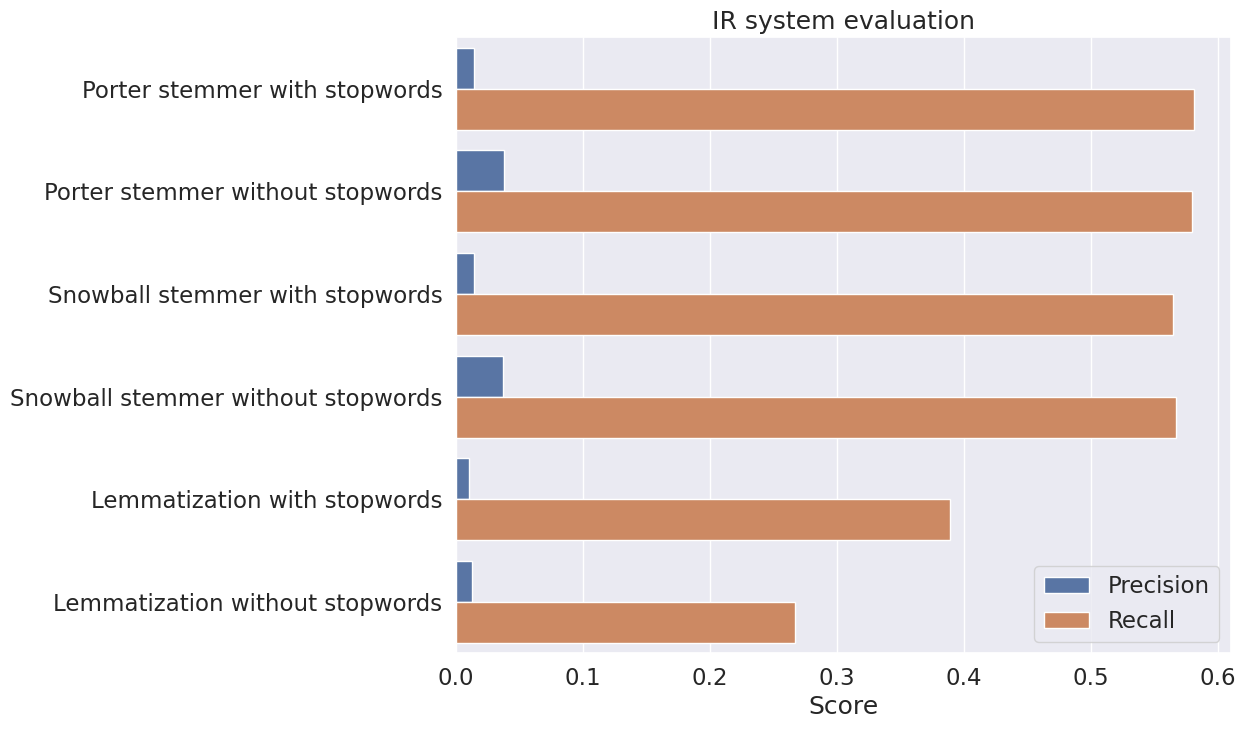

In [131]:
# IR system that uses Porter Stemmer and includes stopwords
porter_with_stopwords = evaluation[(evaluation['word_reduction_type'] == 'stemming_porter') & (evaluation['stopwords'] == 1)]
porter_with_stopwords['Precision'] = porter_with_stopwords['precision'].mean()
porter_with_stopwords['Recall'] = porter_with_stopwords['recall'].mean()
porter_with_stopwords =porter_with_stopwords[['Precision', 'Recall']].drop_duplicates()
porter_with_stopwords['IR_system'] = 'Porter stemmer with stopwords'


# IR system that uses Porter Stemmer and excludes stopwords
porter_without_stopwords = evaluation[(evaluation['word_reduction_type'] == 'stemming_porter') & (evaluation['stopwords'] == 0)]
porter_without_stopwords['Precision'] = porter_without_stopwords['precision'].mean()
porter_without_stopwords['Recall'] = porter_without_stopwords['recall'].mean()
porter_without_stopwords = porter_without_stopwords[['Precision', 'Recall']].drop_duplicates()
porter_without_stopwords['IR_system'] = 'Porter stemmer without stopwords'


# IR system that uses Snowball Stemmer and includes stopwords
snowball_with_stopwords = evaluation[(evaluation['word_reduction_type'] == 'stemming_snowball') & (evaluation['stopwords'] == 1)]
snowball_with_stopwords['Precision'] = snowball_with_stopwords['precision'].mean()
snowball_with_stopwords['Recall'] = snowball_with_stopwords['recall'].mean()
snowball_with_stopwords = snowball_with_stopwords[['Precision', 'Recall']].drop_duplicates()
snowball_with_stopwords['IR_system'] = 'Snowball stemmer with stopwords'

# IR system that uses Snowball Stemmer and excludes stopwords
snowball_without_stopwords = evaluation[(evaluation['word_reduction_type'] == 'stemming_snowball') & (evaluation['stopwords'] == 0)]
snowball_without_stopwords['Precision'] = snowball_without_stopwords['precision'].mean()
snowball_without_stopwords['Recall'] = snowball_without_stopwords['recall'].mean()
snowball_without_stopwords = snowball_without_stopwords[['Precision', 'Recall']].drop_duplicates()
snowball_without_stopwords['IR_system'] = 'Snowball stemmer without stopwords'

# IR system that uses Lemmatization and includes stopwords
lemmatization_with_stopwords = evaluation[(evaluation['word_reduction_type'] == 'lemmatization') & (evaluation['stopwords'] == 1)]
lemmatization_with_stopwords['Precision'] = lemmatization_with_stopwords['precision'].mean()
lemmatization_with_stopwords['Recall'] = lemmatization_with_stopwords['recall'].mean()
lemmatization_with_stopwords = lemmatization_with_stopwords[['Precision', 'Recall']].drop_duplicates()
lemmatization_with_stopwords['IR_system'] = 'Lemmatization with stopwords'

# IR system that uses Lemmatization and excludes stopwords
lemmatization_without_stopwords = evaluation[(evaluation['word_reduction_type'] == 'lemmatization') & (evaluation['stopwords'] == 0)]
lemmatization_without_stopwords['Precision'] = lemmatization_without_stopwords['precision'].mean()
lemmatization_without_stopwords['Recall'] = lemmatization_without_stopwords['recall'].mean()
lemmatization_without_stopwords = lemmatization_without_stopwords[['Precision', 'Recall']].drop_duplicates()
lemmatization_without_stopwords['IR_system'] = 'Lemmatization without stopwords'

# Put all results together
results = pd.concat([porter_with_stopwords, porter_without_stopwords, snowball_with_stopwords, snowball_without_stopwords, lemmatization_with_stopwords, lemmatization_without_stopwords], ignore_index=True)
results = pd.melt(results, id_vars=['IR_system'], value_vars=['Precision', 'Recall'], var_name='score_type', value_name='score')

# Plot results
sns.set_theme(style="whitegrid")
sns.set(rc={'figure.figsize':(10, 8)})
sns.set(font_scale=1.5)
ax = sns.barplot(x="score", y="IR_system", hue="score_type", data=results)
ax.legend(title=None, loc='lower right')
ax.set(xlabel='Score', ylabel=None)
ax.set_title('IR system evaluation')
plt.show()

Precision is always very low, this is due to the fact that the relevance of a document is determined by the presence of a word among the 5 most frequent ones in its lyrics, which is a very strict condition, and it makes the set of relevant documents very small, so $\text{Relevant} \cap \text{Retrieved}$ is always much smaller than $\text{Retrieved}$, and this makes precision very low.

The best results in precision are achieved by the IR systems which exploit stemming instead of lemmatization, and remove the stopwords. Although the difference is not that big, and precision still remains very low.

Stemming seems to be better than lemmatization, and removing stopwords seems to be better than not removing them.

Now let's analyze precision and recall for different query types, to see if the IR system behaves differently with different query types. This time only the best IR system (stemming, no stopwords) will be considered.

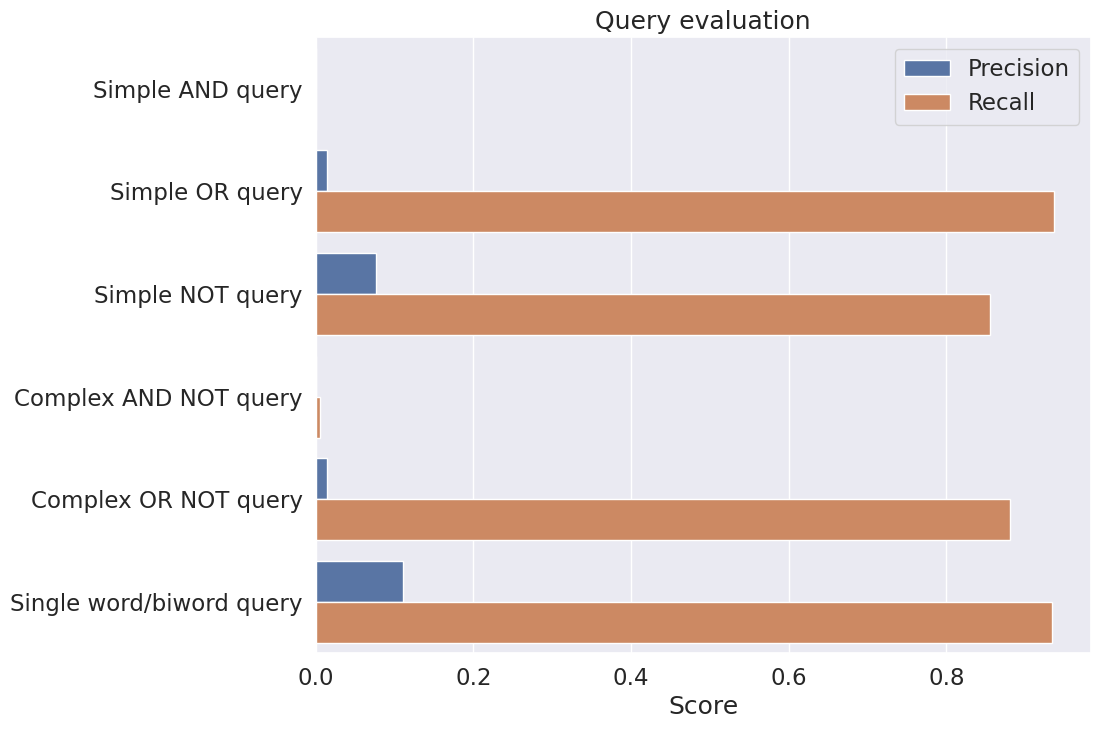

In [137]:
evaluation = evaluation[(evaluation['word_reduction_type'] == 'stemming_porter') | (evaluation['word_reduction_type'] == 'stemming_snowball') & (evaluation['stopwords'] == 0)]

# Simple AND query
simple_and_query = evaluation[evaluation['query_type'] == 1]
simple_and_query['Precision'] = simple_and_query['precision'].mean()
simple_and_query['Recall'] = simple_and_query['recall'].mean()
simple_and_query = simple_and_query[['Precision', 'Recall']].drop_duplicates()
simple_and_query['query_type'] = 'Simple AND query'

# Simple OR query
simple_or_query = evaluation[evaluation['query_type'] == 2]
simple_or_query['Precision'] = simple_or_query['precision'].mean()
simple_or_query['Recall'] = simple_or_query['recall'].mean()
simple_or_query = simple_or_query[['Precision', 'Recall']].drop_duplicates()
simple_or_query['query_type'] = 'Simple OR query'

# Simple NOT query
simple_not_query = evaluation[evaluation['query_type'] == 3]
simple_not_query['Precision'] = simple_not_query['precision'].mean()
simple_not_query['Recall'] = simple_not_query['recall'].mean()
simple_not_query = simple_not_query[['Precision', 'Recall']].drop_duplicates()
simple_not_query['query_type'] = 'Simple NOT query'

# Complex AND NOT query
complex_and_not_query = evaluation[evaluation['query_type'] == 4]
complex_and_not_query['Precision'] = complex_and_not_query['precision'].mean()
complex_and_not_query['Recall'] = complex_and_not_query['recall'].mean()
complex_and_not_query = complex_and_not_query[['Precision', 'Recall']].drop_duplicates()
complex_and_not_query['query_type'] = 'Complex AND NOT query'

# Complex OR NOT query
complex_or_not_query = evaluation[evaluation['query_type'] == 5]
complex_or_not_query['Precision'] = complex_or_not_query['precision'].mean()
complex_or_not_query['Recall'] = complex_or_not_query['recall'].mean()
complex_or_not_query = complex_or_not_query[['Precision', 'Recall']].drop_duplicates()
complex_or_not_query['query_type'] = 'Complex OR NOT query'

# Single word/biword query
single_word_biword_query = evaluation[evaluation['query_type'] == 6]
single_word_biword_query['Precision'] = single_word_biword_query['precision'].mean()
single_word_biword_query['Recall'] = single_word_biword_query['recall'].mean()
single_word_biword_query = single_word_biword_query[['Precision', 'Recall']].drop_duplicates()
single_word_biword_query['query_type'] = 'Single word/biword query'

# Put all results together
results = pd.concat([simple_and_query, simple_or_query, simple_not_query, complex_and_not_query, complex_or_not_query, single_word_biword_query], ignore_index=True)
results = pd.melt(results, id_vars=['query_type'], value_vars=['Precision', 'Recall'], var_name='score_type', value_name='score')

# Plot results
sns.set_theme(style="whitegrid")
sns.set(rc={'figure.figsize':(10, 8)})
sns.set(font_scale=1.5)
ax = sns.barplot(x="score", y="query_type", hue="score_type", data=results)
ax.legend(title=None, loc='upper right')
ax.set(xlabel='Score', ylabel=None)
ax.set_title('Query evaluation')
plt.show()


Unfortunately, for the simple AND queries precision and recall equal 0 due to the fact that the random query generator generated queries with couples of words/biwords that do not appear together among the 5 most frequent ones in the lyrics of the sampled songs, so the set of relevant documents is empty. In fact, it's quite hard to find a couple of words/biwords that appear together in the lyrics of a song, and that are among the 5 most frequent ones, at random.

For the complex AND NOT queries, something similar happens.

As for the rest, the difference among precision and recall maintains the same trend as before, with precision being always very low.

Recall is quite high in all instances (except for queries that contain AND statements), these statistics show no evidence of some kind of bias towards a particular query type, although the system shows the best results with single word/biword queries, where it only has to retrieve documents where the word/biword is present.

## Conclusions

A Boolean Retrieval system is a simple yet somewhat effective technique for Information Retrieval.

The retrieval is very fast, but the creation of the inverted index may be very slow, depending on the size of the collection. This implies that the space required to store the index may be very large.

The system is very strict, and it's not able to retrieve documents that are semantically similar to the query, but do not contain the exact words/bigrams that are specified in the query. In fact, it's an __Exact Retrieval__ approach.

Possible improvements to the system could be:
* Consider n-grams instead of only single words and bigrams
* Consider the tf-idf/wf-idf weighting
* Implement a __Permuterm Index__ to support wildcard queries
* Parallelize the algorithms to speed up the computations
* Try different data structures for the inverted index